# Imports

In [1]:
import helperfunctions as hf

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.padder import PaddingTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.utils.mlflow_sktime import save_model

To generate pip requirements.txt:

`pip list --format=freeze > requirements.txt`

# Training Data

## Data Cleaning for Training Set

In [5]:
# set directories
cwd = os.getcwd()
main_dir = os.path.split(cwd)[0]
data_ils_dir = os.path.join(main_dir, 'dataPackage', 'task-ils')
data_rest_dir = os.path.join(main_dir, 'dataPackage', 'task-rest')
data_pkg_dir = os.path.join(main_dir, 'dataPackage')

In [6]:
# create directory if not exist
output_dir = os.path.join(main_dir,'Cleaned Data')
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
# rest data cleaning
rest_output_dir = os.path.join(main_dir,'Cleaned Data Rest')
if not os.path.isdir(rest_output_dir):
    os.makedirs(rest_output_dir)

In [7]:
# Generate 'cap_name_list', 'level_list', sensor_freq_list
cap_name_list = []
for cp in os.listdir(data_ils_dir):
    if 'cp' in cp:
        cap_name_list.append(cp[-5:])

cap_name_list = pd.DataFrame(data=cap_name_list, columns=['cp_ID'])
cap_name_list.to_csv(os.path.join(data_pkg_dir,'cap_name_list.csv'), index=False)

level_list = {'level': ['01B','02B','03B','04B']}
level_list = pd.DataFrame(level_list)
level_list.to_csv(os.path.join(data_pkg_dir,'level_list.csv'), index=False)

sensor_cutoff_freq_list = {
    'sensor_name': ['lslshimmertorsoacc','lslshimmereda','lslshimmeremg','lslshimmerresp','lslrespitrace','lslshimmerecg'] ,
    'freq': [10,30,5,30,30,30]
    }
sensor_cutoff_freq_list = pd.DataFrame(sensor_cutoff_freq_list)
sensor_cutoff_freq_list.to_csv(os.path.join(data_pkg_dir,'selected_sensor_cutoff_freq.csv'), index=False)

In [8]:
cap_name_list = pd.read_csv(os.path.join(data_pkg_dir,'cap_name_list.csv'))
level_list = pd.read_csv(os.path.join(data_pkg_dir,'level_list.csv'))
sensor_freq_list = pd.read_csv(os.path.join(data_pkg_dir,'selected_sensor_cutoff_freq.csv'))

In [9]:
# data cleaning for ils data - output as 1 file per csv
for cap in cap_name_list['cp_ID']:
    for level in level_list['level']:
        for sensor in sensor_freq_list['sensor_name']:
            try:
                data_csv_list = hf.get_dirs_to_csv(data_ils_dir, cap, level, sensor)
                run = 0
                for csv_dir in data_csv_list:
                    run = run + 1
                    sr = hf.get_csv_freq(csv_dir)
                    cut_off_freq = sensor_freq_list.loc[sensor_freq_list['sensor_name'] == sensor, 'freq'].iloc[0]
                    dsr = np.rint(sr/(cut_off_freq*2))
                    df = pd.read_csv(csv_dir)
                    # remove from df before simulation start and after simulation ends (12 Dec new)
                    head, tail = hf.get_head_tail_time_to_remove(csv_dir)
                    # remove before start
                    if head > 0:
                        head_rows = head * sr
                        head_rows = int(head_rows) + (head_rows % 1 > 0)
                        df = df.drop(df.index[:head_rows])
                    #remove after stop
                    if tail > 0:
                        tail_rows = tail * sr
                        tail_rows = int(tail_rows) + (tail_rows % 1 > 0)
                        df = df.drop(df.index[-tail_rows:])
                    # end of 12 Dec New added code
                    df_out = pd.DataFrame()
                    cols, times = [], []
                    for column in df:
                        if column != 'time_dn':
                            cols.append(column)
                            df1 = df[column]
                            X = np.fft.fft(df1,axis=0)
                            X_lpf = X
                            X_lpf[cut_off_freq*sr:] = 0
                            Y_lpf = np.fft.ifft(X_lpf,axis=0)
                            Y_lpf = Y_lpf.real
                            Y_dsp = Y_lpf[::int(dsr)]
                            df_out = pd.concat([df_out, pd.DataFrame(Y_dsp)], axis=1)
                            
                    df_out.columns = cols
                    # add time column
                    for i in range(df_out.shape[0]):
                        times.append(i*1/(cut_off_freq*2))
                    df_out.insert(0, 'Time', times)
                    output_csv = os.path.join(output_dir, f"{sensor}_{level}_{cap}_{run}.csv")
                    df_out.to_csv(output_csv, index=False)
            except:
                print (cap, level, sensor, run)
                pass


cp009 01B lslshimmereda 1
cp009 01B lslshimmerresp 1
cp009 01B lslshimmerecg 1
cp009 02B lslshimmereda 1
cp009 02B lslshimmerresp 1
cp009 02B lslshimmerecg 1
cp009 03B lslshimmereda 1
cp009 03B lslshimmerresp 1
cp009 03B lslshimmerecg 1
cp009 04B lslshimmereda 1
cp009 04B lslshimmerresp 1
cp009 04B lslshimmerecg 1
cp028 01B lslshimmeremg 3


In [10]:
# data cleaning for rest data - output as 1 file per csv
level = '000'
for cap in cap_name_list['cp_ID']:
        for sensor in sensor_freq_list['sensor_name']:
            try:
                data_csv_list = hf.get_dirs_to_csv(data_rest_dir, cap, level, sensor)
                run = 0
                for csv_dir in data_csv_list:
                    run = run + 1
                    sr = hf.get_csv_freq(csv_dir)
                    cut_off_freq = sensor_freq_list.loc[sensor_freq_list['sensor_name'] == sensor, 'freq'].iloc[0]
                    dsr = np.rint(sr/(cut_off_freq*2))
                    df = pd.read_csv(csv_dir)

                    df_out = pd.DataFrame()
                    cols, times = [], []
                    for column in df:
                        if column != 'time_dn':
                            cols.append(column)
                            df1 = df[column]
                            X = np.fft.fft(df1,axis=0)
                            X_lpf = X
                            X_lpf[cut_off_freq*sr:] = 0
                            Y_lpf = np.fft.ifft(X_lpf,axis=0)
                            Y_lpf = Y_lpf.real
                            Y_dsp = Y_lpf[::int(dsr)]
                            df_out = pd.concat([df_out, pd.DataFrame(Y_dsp)], axis=1)

                            # output_csv = os.path.join(rest_output_dir, f"{sensor}_{column}_{level}_{cap}_{run}.csv")
                            # df_out = pd.DataFrame(Y_dsp)
                            # df_out.columns = [column]
                            # df_out.to_csv(output_csv, index=False)
                        
                    df_out.columns = cols
                    # add time column
                    for i in range(df_out.shape[0]):
                        times.append(i*1/(cut_off_freq*2))
                    df_out.insert(0, 'Time', times)
                    output_csv = os.path.join(rest_output_dir, f"{sensor}_{level}_{cap}_{run}.csv")
                    df_out.to_csv(output_csv, index=False)
            except:
                 print (cap, level, sensor, run)
                 pass


cp009 000 lslshimmereda 1
cp009 000 lslshimmerresp 1
cp009 000 lslshimmerecg 1
cp028 000 lslshimmeremg 2
cp042 000 lslshimmeremg 1


## Generate 5 folds for train test split

In [6]:
# subjects2 = ['cp004', 'cp005', 'cp006', 'cp008', 'cp011', 'cp012', 'cp013', 'cp014', 'cp015', 'cp016']
subjects2 = [i for i in range(1,34)]

# Split
train, test = [], []

grpkfold = GroupKFold(n_splits=5)
for train_i, test_i in grpkfold.split(X=subjects2, groups=subjects2):
    train.append(train_i)
    test.append(test_i)

train_splits, test_splits = {}, {}

for i, fold in enumerate(train):
    train_splits[i] = []
    for j in fold:
        train_splits[i].append(subjects2[j])

for i, fold in enumerate(test):
    test_splits[i] = []
    for j in fold:
        test_splits[i].append(subjects2[j])

# Check splits
for i in range(5):
    print(train_splits[i])
    print(test_splits[i])
    print(len(train_splits[i]) + len(test_splits[i]))
    print()

[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32]
[5, 10, 15, 20, 25, 30, 33]
33

[1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33]
[6, 11, 16, 17, 21, 26, 31]
33

[3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33]
[1, 2, 7, 12, 22, 27, 32]
33

[1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 26, 27, 29, 30, 31, 32, 33]
[3, 8, 13, 18, 23, 28]
33

[1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33]
[4, 9, 14, 19, 24, 29]
33



In [7]:
data_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Cleaned Data'
target_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ready for ML_folds'

# Get list of subjects
data_files = hf.get_all_data_csv_filenames(data_dir)
split_files = [i.split('_') for i in data_files]
subjects = [i[2] for i in split_files]
subjects = list(set(subjects))
subjects.sort()

# Split
train, test = [], []

grpkfold = GroupKFold(n_splits=5)
for train_i, test_i in grpkfold.split(X=subjects, groups=subjects):
    train.append(train_i)
    test.append(test_i)

train_splits, test_splits = {}, {}

for i, fold in enumerate(train):
    train_splits[i] = []
    for j in fold:
        train_splits[i].append(subjects[j])

for i, fold in enumerate(test):
    test_splits[i] = []
    for j in fold:
        test_splits[i].append(subjects[j])

In [8]:
# Check splits
for i in range(5):
    # print(train_splits[i])
    print(test_splits[i])
    print(len(train_splits[i]) + len(test_splits[i]))
    print()

['cp004', 'cp011', 'cp016', 'cp028', 'cp033', 'cp039', 'cp043']
35

['cp009', 'cp013', 'cp015', 'cp020', 'cp027', 'cp031', 'cp038']
35

['cp008', 'cp014', 'cp019', 'cp023', 'cp024', 'cp026', 'cp037']
35

['cp006', 'cp012', 'cp018', 'cp025', 'cp030', 'cp036', 'cp042']
35

['cp003', 'cp005', 'cp017', 'cp022', 'cp029', 'cp032', 'cp035']
35



# Individual data types

## EMG

## Electrodermal Activity (EDA) - Photoplethysmogram (PPG) sensor

In [ ]:
# ComposableTimeSeriesForestClassifier, n_estimators=100, bootstrap=True

lslshimmereda_ppg_finger_mV_01B_cp003_1.csv


<IPython.core.display.Javascript object>


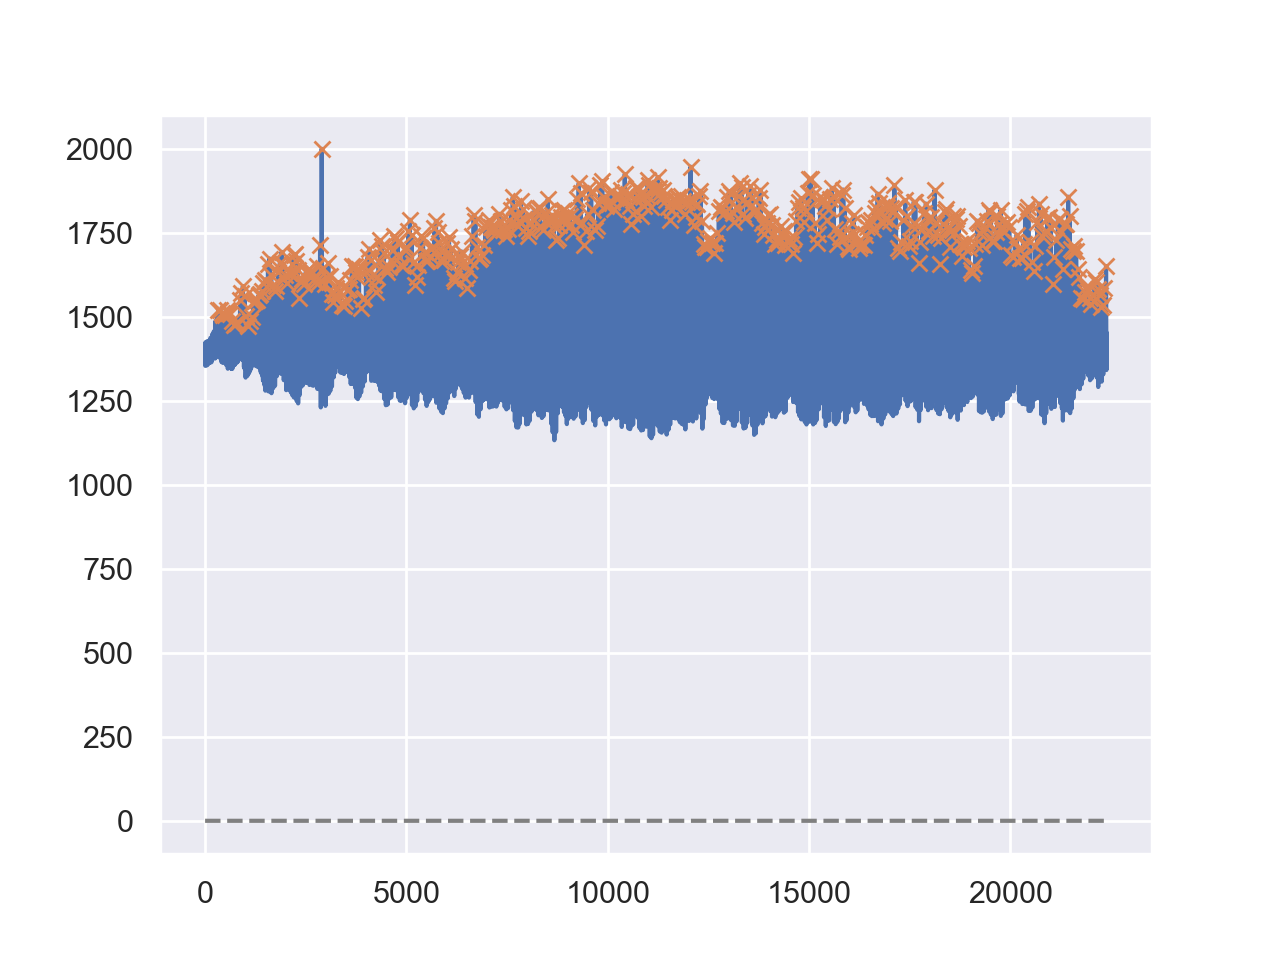

lslshimmereda_ppg_finger_mV_01B_cp003_2.csv
lslshimmereda_ppg_finger_mV_01B_cp003_3.csv
lslshimmereda_ppg_finger_mV_01B_cp008_1.csv
lslshimmereda_ppg_finger_mV_01B_cp008_2.csv
lslshimmereda_ppg_finger_mV_01B_cp008_3.csv
lslshimmereda_ppg_finger_mV_01B_cp009_1.csv
lslshimmereda_ppg_finger_mV_01B_cp009_2.csv
lslshimmereda_ppg_finger_mV_01B_cp011_1.csv
lslshimmereda_ppg_finger_mV_01B_cp011_2.csv
lslshimmereda_ppg_finger_mV_01B_cp011_3.csv
lslshimmereda_ppg_finger_mV_01B_cp012_1.csv
lslshimmereda_ppg_finger_mV_01B_cp012_2.csv
lslshimmereda_ppg_finger_mV_01B_cp012_3.csv
lslshimmereda_ppg_finger_mV_01B_cp014_1.csv
lslshimmereda_ppg_finger_mV_01B_cp014_2.csv
lslshimmereda_ppg_finger_mV_01B_cp014_3.csv
lslshimmereda_ppg_finger_mV_01B_cp015_1.csv
lslshimmereda_ppg_finger_mV_01B_cp015_2.csv
lslshimmereda_ppg_finger_mV_01B_cp015_3.csv
lslshimmereda_ppg_finger_mV_01B_cp016_1.csv
lslshimmereda_ppg_finger_mV_01B_cp016_2.csv
lslshimmereda_ppg_finger_mV_01B_cp016_3.csv
lslshimmereda_ppg_finger_mV_01B_

In [ ]:
# read each file to create feature row
# window size of 20s, step of 10s, freq = 60Hz
window_sec = 20
window = int(window_sec * 60)
step = int(window_sec * 30)
# holder for all features
arr_f_all = []
for f in df1['file_name']:
    print(f)
    # read sensor data and create single row holder
    df_f = pd.read_csv(os.path.join(data_clean_dir,f))
    arr_f = []
    # create window slice
    for i in range (0, len(df_f), step):
        slice = df_f.iloc[i:i + window]
        peaks = find_peaks(slice)
        heart_rate = find_median_heart_rate(peaks)
        arr_f.append(heart_rate)
    # check if the last value is NaN, if so, drop it
    if np.isnan(arr_f[-1]):
        arr_f = arr_f[:-1]
    # append single feature to total feature
    arr_f_all.append(arr_f)
    # save plot to file
    plt.plot(arr_f)
    plt.title(f[:-4])
    plt.savefig(os.path.join(output_plot_dir, f"{f[:-4]}.png"))
    plt.clf()
# convert to dataframe for merger with ftr index
df_ftr = pd.DataFrame(arr_f_all)
df = pd.concat([df1, df_ftr], axis = 1)
df.to_csv(os.path.join(output_dir, f"eda_ppg_window_{window_sec}s.csv"), na_rep='', index = False)

### Generate combined numpy data file for ML model training
Heart rate data is generated from PPG and a heart rate is calculated every 10 seconds

In [60]:
# Combine all lslshimmereda files with Standard Scaling

data_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Cleaned Data'
target_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ready for ML_final'
hz = 60
sensor = 'lslshimmereda'
scaler = StandardScaler()
subject = ''
level = ''

# Standard scaling
file_suffix = 'train_lslshimmereda_standard_padtransform'
hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, hz, sensor, subject, level)

(396, 4)
396
2
X shape: (396, 2, 44865)
y shape: (396,)
Saved files:
	X_train_lslshimmereda_standard_padtransform.npy
	y_train_lslshimmereda_standard_padtransform.npy


In [61]:
# Generate heart rate list, keep list of erroneous data

import heartpy as hp

data_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Cleaned Data'
sensor = 'lslshimmereda'
subject = ''
level = ''
df_runs = hf.get_df_runs(data_dir, sensor, subject, level)

X_train_lslshimmereda_ppg_finger_mV = np.load(target_dir+'\X_train_lslshimmereda_standard_padtransform.npy')

bpm_list = []
error_list = []
for i in range(X_train_lslshimmereda_ppg_finger_mV.shape[0]):
    # get non zero values only
    idx = np.nonzero(X_train_lslshimmereda_ppg_finger_mV[i,0,:])
    hr_data = X_train_lslshimmereda_ppg_finger_mV[i,0,:][idx]

    hz=60
    segment_len=10
    end_row = len(hr_data) // (hz*segment_len) * hz*segment_len

    try:
        bpm = []
        for j in range(hz*segment_len, end_row+2, hz*segment_len):
            working_data, measures = hp.process(hr_data[j-(hz*segment_len):j], hz)
            bpm.append(measures['bpm'])
        df_runs
        bpm_list.append(bpm)
    except:
        error_list.append(i)

print(len(bpm_list))

(396, 4)
396


c:\Users\shiuh\miniconda3\envs\pilotperf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shiuh\miniconda3\envs\pilotperf\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\shiuh\miniconda3\envs\pilotperf\lib\site-packages\numpy\ma\core.py:5288: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
c:\Users\shiuh\miniconda3\envs\pilotperf\lib\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\shiuh\miniconda3\envs\pilotperf\lib\site-packages\scipy\interpolate\_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been

353


In [86]:
# Generate df with raw bpm data, save it

df_bpm_raw = df_runs.drop(error_list)
df_bpm_raw.reset_index(inplace=True, drop=True)
tmp_bpm_df = pd.DataFrame({'bpm': bpm_list})
df_bpm_raw = pd.concat([df_bpm_raw, tmp_bpm_df], axis=1)
# df_bpm_raw.loc[:,'difficulty'] = df_bpm_raw['difficulty'].replace({'01B': 0, '02B': 1, '03B': 2, '04B': 3})
df_bpm_raw.to_pickle(target_dir+r'\bpm_raw.pkl')

df_bpm_raw.head()

,subject,difficulty,run,time,bpm
0,cp003,01B,1,427.933333,"[84.62929475587704, 67.66917293233082, 64.5161..."
1,cp003,01B,2,444.816667,"[87.04663212435233, 60.431654676258994, 62.912..."
2,cp003,01B,3,442.550000,"[80.16194331983806, 64.74820143884892, 67.4157..."
3,cp004,01B,3,406.150000,"[222.47191011235952, nan, nan, 153.19148936170..."
4,cp005,01B,1,425.683333,"[125.87412587412588, 203.9408866995074, 86.399..."


In [98]:
# Standard scale bpm, save it

df_bpm_scaled = df_bpm_raw.copy()
scaler = StandardScaler()

def scaling_operation(x):
    arr = np.array(x)
    return scaler.fit_transform(arr.reshape(-1, 1)).flatten()

df_bpm_scaled.loc[:,'bpm'] = df_bpm_scaled['bpm'].apply(scaling_operation)
df_bpm_scaled.to_pickle(target_dir + r'\bpm_scaled.pkl')

df_bpm_scaled.head()

,subject,difficulty,run,time,bpm
0,cp003,01B,1,427.933333,"[2.108540878701124, -0.08670077010744036, -0.4..."
1,cp003,01B,2,444.816667,"[4.589652562683285, -1.9405936654840066, -1.33..."
2,cp003,01B,3,442.550000,"[3.1464547584969362, -0.44889363807732385, 0.1..."
3,cp004,01B,3,406.150000,"[0.04112048312805656, nan, nan, -0.55098341883..."
4,cp005,01B,1,425.683333,"[-0.2757147313204034, 0.8496122985748833, -0.8..."


In [125]:
# Pad and save as numpy file ready for ML training

df_bpm_scaled['bpm_length'] = df_bpm_scaled['bpm'].apply(lambda x: len(x))
pad_length = df_bpm_scaled['bpm_length'].max()+1
padder = PaddingTransformer(pad_length)
df_bpm_scaled['bpm_padded'] = df_bpm_scaled['bpm'].apply(lambda x: padder.fit_transform(x).flatten())

X = np.array(list(df_bpm_scaled['bpm_padded']))
y = df_bpm_scaled['difficulty'].replace({'01B': 0, '02B': 1, '03B': 2, '04B': 3})

np.save(target_dir + r'\X_train_lslshimmereda_heartrate_standard_padtransform.npy', X)
np.save(target_dir + r'\y_train_lslshimmereda_heartrate_standard_padtransform.npy', y)

df_bpm_scaled.head()

,subject,difficulty,run,time,bpm,bpm_length,bpm_padded
0,cp003,01B,1,427.933333,"[2.108540878701124, -0.08670077010744036, -0.4...",42,"[2.108540878701124, -0.08670077010744036, -0.4..."
1,cp003,01B,2,444.816667,"[4.589652562683285, -1.9405936654840066, -1.33...",44,"[4.589652562683285, -1.9405936654840066, -1.33..."
2,cp003,01B,3,442.550000,"[3.1464547584969362, -0.44889363807732385, 0.1...",44,"[3.1464547584969362, -0.44889363807732385, 0.1..."
3,cp004,01B,3,406.150000,"[0.04112048312805656, nan, nan, -0.55098341883...",40,"[0.04112048312805656, nan, nan, -0.55098341883..."
4,cp005,01B,1,425.683333,"[-0.2757147313204034, 0.8496122985748833, -0.8...",42,"[-0.2757147313204034, 0.8496122985748833, -0.8..."


### Train model on full set of training data

In [8]:
from sktime.classification.compose import ComposableTimeSeriesForestClassifier

data_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ready for ML_final'
model_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Trained Models'

X_train = np.load(data_dir + '\\' + 'X_train_lslshimmereda_heartrate_standard_padtransform.npy')
y_train = np.load(data_dir + '\\' + 'y_train_lslshimmereda_heartrate_standard_padtransform.npy')

clf = ComposableTimeSeriesForestClassifier(n_estimators=100, bootstrap=True, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)

# Save model
with open(model_dir + r'\ppgHeartrate.pkl', 'wb') as f:
    pickle.dump(clf, f)

ValueError: Data seen by ComposableTimeSeriesForestClassifier instance has missing values, but this ComposableTimeSeriesForestClassifier instance cannot handle missing values. Calls with missing values may result in error or unreliable results.

## ECG

## Respiration (from Shimmer Device)

In [ ]:
# SupervisedTimeSeriesForest with 40 estimators

### Generate combined numpy data file for ML model training

In [4]:
# Generate full training data for respiration from Shimmer

data_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Cleaned Data'
target_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ready for ML_final'
hz = 60
sensor = 'lslshimmerresp'
subject = ''
level = ''

# StandardScaler
file_suffix = 'train_lslshimmerresp_standard_padtransform'
scaler = StandardScaler()
hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, hz, sensor, subject, level)

(407, 4)
407
X shape: (407, 1, 48024)
y shape: (407,)
Saved files:
	X_train_lslshimmerresp_standard_padtransform.npy
	y_train_lslshimmerresp_standard_padtransform.npy


### Train model on full set of training data

In [6]:
from sktime.classification.interval_based import SupervisedTimeSeriesForest

data_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ready for ML_final'
model_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Trained Models'

X_train = np.load(data_dir + '\\' + 'X_train_lslshimmerresp_standard_padtransform.npy')
y_train = np.load(data_dir + '\\' + 'y_train_lslshimmerresp_standard_padtransform.npy')

clf = SupervisedTimeSeriesForest(n_estimators=40, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)

# Save model
with open(model_dir + r'\shimmerResp.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [7]:
# Load model
# with open(model_dir + r'\shimmerResp.pkl', 'rb') as f:
#     clf = pickle.load(f)

# y_pred_proba = clf.predict_proba(X_train)
# y_pred = clf.predict(X_train)

# acc = accuracy_score(y_train, y_pred)
# auc = roc_auc_score(y_train, y_pred_proba, multi_class='ovr', average = 'macro')
# f1 = f1_score(y_train, y_pred, average='macro')

# print(acc)
# print(auc)
# print(f1)

1.0
1.0
1.0


### Validate model on training data folds
#### Generate folds

In [71]:
# Generate folds of training data

data_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Cleaned Data'
target_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ready for ML_validation'
hz = 60
sensor = 'lslshimmerresp'
level = ''

scaler = StandardScaler()

for i in train_splits:
    file_suffix = f'train_lslshimmerresp_standard_padtransform{i}'
    subject = train_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, hz, sensor, subject, level)
    print()

Number of runs detected: 323
X shape: (323, 1, 48024)
y shape: (323,)
Saved files:
	X_train_lslshimmerresp_standard_padtransform0.npy
	y_train_lslshimmerresp_standard_padtransform0.npy

Number of runs detected: 335
X shape: (335, 1, 48024)
y shape: (335,)
Saved files:
	X_train_lslshimmerresp_standard_padtransform1.npy
	y_train_lslshimmerresp_standard_padtransform1.npy

Number of runs detected: 323
X shape: (323, 1, 48024)
y shape: (323,)
Saved files:
	X_train_lslshimmerresp_standard_padtransform2.npy
	y_train_lslshimmerresp_standard_padtransform2.npy

Number of runs detected: 324
X shape: (324, 1, 48024)
y shape: (324,)
Saved files:
	X_train_lslshimmerresp_standard_padtransform3.npy
	y_train_lslshimmerresp_standard_padtransform3.npy

Number of runs detected: 323
X shape: (323, 1, 48024)
y shape: (323,)
Saved files:
	X_train_lslshimmerresp_standard_padtransform4.npy
	y_train_lslshimmerresp_standard_padtransform4.npy



In [72]:
# Generate folds of test data

for i in test_splits:
    file_suffix = f'test_lslshimmerresp_standard_padtransform{i}'
    subject = test_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, hz, sensor, subject, level)
    print()

Number of runs detected: 84
X shape: (84, 1, 48024)
y shape: (84,)
Saved files:
	X_test_lslshimmerresp_standard_padtransform0.npy
	y_test_lslshimmerresp_standard_padtransform0.npy

Number of runs detected: 72
X shape: (72, 1, 48024)
y shape: (72,)
Saved files:
	X_test_lslshimmerresp_standard_padtransform1.npy
	y_test_lslshimmerresp_standard_padtransform1.npy

Number of runs detected: 84
X shape: (84, 1, 48024)
y shape: (84,)
Saved files:
	X_test_lslshimmerresp_standard_padtransform2.npy
	y_test_lslshimmerresp_standard_padtransform2.npy

Number of runs detected: 83
X shape: (83, 1, 48024)
y shape: (83,)
Saved files:
	X_test_lslshimmerresp_standard_padtransform3.npy
	y_test_lslshimmerresp_standard_padtransform3.npy

Number of runs detected: 84
X shape: (84, 1, 48024)
y shape: (84,)
Saved files:
	X_test_lslshimmerresp_standard_padtransform4.npy
	y_test_lslshimmerresp_standard_padtransform4.npy



#### Set up model

In [2]:
from sktime.classification.interval_based import SupervisedTimeSeriesForest

def respshimmer_folds(n_estimators=40, n_jobs=-1, random_state=42, result_CV = None):
    path = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ready for ML_validation'
    probabilities = {}

    for i in range(5):
        X_train = np.load(path + '\\' + f'X_train_lslshimmerresp_standard_padtransform{i}.npy')
        y_train = np.load(path + '\\' + f'y_train_lslshimmerresp_standard_padtransform{i}.npy')
        X_test = np.load(path + '\\' + f'X_test_lslshimmerresp_standard_padtransform{i}.npy')
        y_test = np.load(path + '\\' + f'y_test_lslshimmerresp_standard_padtransform{i}.npy')

        clf = SupervisedTimeSeriesForest(n_estimators, n_jobs, random_state)

        clf.fit(X_train, y_train)
        y_pred_proba_SupervisedTimeSeriesForest = clf.predict_proba(X_test)
        probabilities[i] = y_pred_proba_SupervisedTimeSeriesForest
        # Log results
        class_list = [0,1,2,3]
        result_CV = hf.log_result(f'Set {i}', class_list, y_test, y_pred_proba_SupervisedTimeSeriesForest, result_CV)
        
        print(f'\rFold {i} complete', end='')
    print()
    return result_CV, probabilities

#### Runs

In [77]:
%%time

result, _ = respshimmer_folds(40, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 12.4 s
Wall time: 8min 49s


accuracy_score    0.373111
AUC_score         0.630991
F1_score          0.354807
dtype: float64

In [3]:
%%time

result, _ = respshimmer_folds(50, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 17.2 s
Wall time: 9min 24s


accuracy_score    0.402931
AUC_score         0.647100
F1_score          0.378989
dtype: float64

In [4]:
%%time

result, _ = respshimmer_folds(60, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 24.2 s
Wall time: 11min 11s


accuracy_score    0.373848
AUC_score         0.644333
F1_score          0.347194
dtype: float64

In [5]:
%%time

result, _ = respshimmer_folds(70, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 29.3 s
Wall time: 12min 56s


accuracy_score    0.370731
AUC_score         0.644125
F1_score          0.342514
dtype: float64

In [6]:
%%time

result, _ = respshimmer_folds(80, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 38.3 s
Wall time: 15min 20s


accuracy_score    0.375464
AUC_score         0.651196
F1_score          0.347768
dtype: float64

In [7]:
%%time

result, _ = respshimmer_folds(90, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 44.7 s
Wall time: 18min 20s


accuracy_score    0.378356
AUC_score         0.648205
F1_score          0.348122
dtype: float64

In [8]:
%%time

result, _ = respshimmer_folds(100, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 55.3 s
Wall time: 19min


accuracy_score    0.384648
AUC_score         0.645720
F1_score          0.354331
dtype: float64

In [9]:
%%time

result, _ = respshimmer_folds(110, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 1min 6s
Wall time: 19min 57s


accuracy_score    0.379518
AUC_score         0.645322
F1_score          0.349614
dtype: float64

In [10]:
%%time

result, _ = respshimmer_folds(200, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 2min 49s
Wall time: 35min 54s


accuracy_score    0.371806
AUC_score         0.646544
F1_score          0.344480
dtype: float64

#### Generate probabilities for ensemble model

In [11]:
%%time

result, probabilities = respshimmer_folds(50, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 16.8 s
Wall time: 8min 44s


accuracy_score    0.402931
AUC_score         0.647100
F1_score          0.378989
dtype: float64

In [12]:
pd.DataFrame(probabilities[0])

,0,1,2,3
0,0.58,0.10,0.14,0.18
1,0.54,0.10,0.12,0.24
2,0.42,0.14,0.18,0.26
3,0.36,0.22,0.28,0.14
4,0.24,0.18,0.22,0.36
...,...,...,...,...
79,0.04,0.28,0.44,0.24
80,0.26,0.30,0.20,0.24
81,0.08,0.28,0.36,0.28
82,0.04,0.22,0.46,0.28


In [17]:
data_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Cleaned Data'
hz = 60
sensor = 'lslshimmerresp'
level = ''
# subject = test_splits[0]
# df_runs = hf.get_df_runs(data_dir, sensor, subject, level, True)

df_combined = pd.DataFrame()
split_df_list = []
for i in range(5):
    subject = test_splits[i]
    df_runs = hf.get_df_runs(data_dir, sensor, subject, level, True)
    df_runs = df_runs.drop('time', axis=1)
    df_proba = pd.DataFrame(probabilities[i])
    df_proba.columns = ['lslshimmerresp_01B', 'lslshimmerresp_02B', 'lslshimmerresp_03B', 'lslshimmerresp_04B']
    df_cur = pd.concat([df_runs, df_proba], axis=1)
    split_df_list.append(df_cur)
    df_combined = pd.concat([df_combined, df_cur], axis=0)

Number of runs detected: 84
Number of runs detected: 72
Number of runs detected: 84
Number of runs detected: 83
Number of runs detected: 84


In [19]:
# Save the probabilities

target_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ensembled'

df_combined_lslshimmerresp = df_combined.copy()
df_combined_lslshimmerresp = df_combined_lslshimmerresp.sort_values(['subject','difficulty','run'], axis = 0)
df_combined_lslshimmerresp = df_combined_lslshimmerresp.reset_index(drop = True)
df_combined_lslshimmerresp.to_csv(target_dir+r'\lslshimmerresp_ensembled_training.csv', index=False)
df_combined_lslshimmerresp

,subject,difficulty,run,lslshimmerresp_01B,lslshimmerresp_02B,lslshimmerresp_03B,lslshimmerresp_04B
0,cp003,01B,1,0.44,0.22,0.14,0.20
1,cp003,01B,2,0.24,0.22,0.22,0.32
2,cp003,01B,3,0.46,0.24,0.18,0.12
3,cp003,02B,1,0.20,0.28,0.28,0.24
4,cp003,02B,2,0.12,0.22,0.42,0.24
...,...,...,...,...,...,...,...
402,cp043,03B,2,0.04,0.28,0.44,0.24
403,cp043,03B,3,0.26,0.30,0.20,0.24
404,cp043,04B,1,0.08,0.28,0.36,0.28
405,cp043,04B,2,0.04,0.22,0.46,0.28


## Respiration (from Respitrace Device)

## TorsoACC

### Generate combined numpy data file for ML model training

In [ ]:
# Generate full training data for TorsoACC

data_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Cleaned Data'
target_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ready for ML_final'
hz = 20
sensor = 'lslshimmertorsoacc'
subject = ''
level = ''

# MinMaxScaler
file_suffix = 'train_lslshimmertorsoacc_minmax_padtransform'
scaler = MinMaxScaler()
hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, hz, sensor, subject, level)

# StandardScaler
file_suffix = 'train_lslshimmertorsoacc_standard_padtransform'
scaler = StandardScaler()
hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, hz, sensor, subject, level)

(390, 4)
390
X shape: (390, 3, 15969)
y shape: (390,)
Saved files:
	X_train_lslshimmertorsoacc_minmax_padtransform.npy
	y_train_lslshimmertorsoacc_minmax_padtransform.npy
(390, 4)
390
X shape: (390, 3, 15969)
y shape: (390,)
Saved files:
	X_train_lslshimmertorsoacc_standard_padtransform.npy
	y_train_lslshimmertorsoacc_standard_padtransform.npy


### Train model on full set of training data

In [48]:
%%time
from sktime.classification.feature_based import SignatureClassifier

data_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ready for ML_final'
model_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Trained Models'

X_train = np.load(data_dir + '\\' + 'X_train_lslshimmertorsoacc_standard_padtransform.npy')
y_train = np.load(data_dir + '\\' + 'y_train_lslshimmertorsoacc_standard_padtransform.npy')

clf = ColumnEnsembleClassifier(
    estimators=[
        ("est1", SignatureClassifier(estimator=None, augmentation_list=('basepoint', 'addtime'), window_name="sliding", window_length=15, window_step=15, rescaling=None, sig_tfm='signature', depth=4, random_state=42), [0]),
        ("est2", SignatureClassifier(estimator=None, augmentation_list=('basepoint', 'addtime'), window_name="sliding", window_length=15, window_step=15, rescaling=None, sig_tfm='signature', depth=4, random_state=42), [1]),
        ("est3", SignatureClassifier(estimator=None, augmentation_list=('basepoint', 'addtime'), window_name="sliding", window_length=15, window_step=15, rescaling=None, sig_tfm='signature', depth=4, random_state=42), [2]),
    ]
)

clf.fit(X_train, y_train)

# Save model
# with open(model_dir + r'\torsoACC.pkl', 'wb') as f:
#     pickle.dump(clf, f)

CPU times: total: 22min 16s
Wall time: 22min 53s


ColumnEnsembleClassifier(estimators=[('est1',
                                      SignatureClassifier(random_state=42,
                                                          window_length=15,
                                                          window_name='sliding',
                                                          window_step=15),
                                      [0]),
                                     ('est2',
                                      SignatureClassifier(random_state=42,
                                                          window_length=15,
                                                          window_name='sliding',
                                                          window_step=15),
                                      [1]),
                                     ('est3',
                                      SignatureClassifier(random_state=42,
                                                          window_length=15,
                                                          window_name='sliding',
                                                          window_step=15),
                                      [2])])

In [8]:
# Load model
# with open(model_dir + r'\torsoACC2.pkl', 'rb') as f:
#     clf = pickle.load(f)

### Validate model on training data folds

#### Generate folds

In [44]:
# Generate folds of training data

data_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Cleaned Data'
target_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ready for ML_validation'
hz = 20
sensor = 'lslshimmertorsoacc'
level = ''

scaler = StandardScaler()

for i in train_splits:
    file_suffix = f'train_lslshimmertorsoacc_standard_padtransform{i}'
    subject = train_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, hz, sensor, subject, level)
    print()

Number of runs detected: 306
X shape: (306, 3, 15969)
y shape: (306,)
Saved files:
	X_train_lslshimmertorsoacc_standard_padtransform0.npy
	y_train_lslshimmertorsoacc_standard_padtransform0.npy

Number of runs detected: 318
X shape: (318, 3, 15969)
y shape: (318,)
Saved files:
	X_train_lslshimmertorsoacc_standard_padtransform1.npy
	y_train_lslshimmertorsoacc_standard_padtransform1.npy

Number of runs detected: 311
X shape: (311, 3, 15969)
y shape: (311,)
Saved files:
	X_train_lslshimmertorsoacc_standard_padtransform2.npy
	y_train_lslshimmertorsoacc_standard_padtransform2.npy

Number of runs detected: 307
X shape: (307, 3, 15969)
y shape: (307,)
Saved files:
	X_train_lslshimmertorsoacc_standard_padtransform3.npy
	y_train_lslshimmertorsoacc_standard_padtransform3.npy

Number of runs detected: 318
X shape: (318, 3, 15969)
y shape: (318,)
Saved files:
	X_train_lslshimmertorsoacc_standard_padtransform4.npy
	y_train_lslshimmertorsoacc_standard_padtransform4.npy



In [45]:
# Generate folds of test data

for i in test_splits:
    file_suffix = f'test_lslshimmertorsoacc_standard_padtransform{i}'
    subject = test_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, hz, sensor, subject, level)
    print()

Number of runs detected: 84
X shape: (84, 3, 15969)
y shape: (84,)
Saved files:
	X_test_lslshimmertorsoacc_standard_padtransform0.npy
	y_test_lslshimmertorsoacc_standard_padtransform0.npy

Number of runs detected: 72
X shape: (72, 3, 15969)
y shape: (72,)
Saved files:
	X_test_lslshimmertorsoacc_standard_padtransform1.npy
	y_test_lslshimmertorsoacc_standard_padtransform1.npy

Number of runs detected: 79
X shape: (79, 3, 15969)
y shape: (79,)
Saved files:
	X_test_lslshimmertorsoacc_standard_padtransform2.npy
	y_test_lslshimmertorsoacc_standard_padtransform2.npy

Number of runs detected: 83
X shape: (83, 3, 15969)
y shape: (83,)
Saved files:
	X_test_lslshimmertorsoacc_standard_padtransform3.npy
	y_test_lslshimmertorsoacc_standard_padtransform3.npy

Number of runs detected: 72
X shape: (72, 3, 15969)
y shape: (72,)
Saved files:
	X_test_lslshimmertorsoacc_standard_padtransform4.npy
	y_test_lslshimmertorsoacc_standard_padtransform4.npy



#### Set up model

In [2]:
from sktime.classification.feature_based import SignatureClassifier

def torsoracc_folds(window_name, window_length, window_step, depth, random_state=None, result_CV=None):
    path = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ready for ML_validation'
    probabilities = {}

    for i in range(5):
        X_train = np.load(path + '\\' + f'X_train_lslshimmertorsoacc_standard_padtransform{i}.npy')
        y_train = np.load(path + '\\' + f'y_train_lslshimmertorsoacc_standard_padtransform{i}.npy')
        X_test = np.load(path + '\\' + f'X_test_lslshimmertorsoacc_standard_padtransform{i}.npy')
        y_test = np.load(path + '\\' + f'y_test_lslshimmertorsoacc_standard_padtransform{i}.npy')

        clf = ColumnEnsembleClassifier(
            estimators=[
                ("est1", SignatureClassifier(window_name = window_name, window_length = window_length, window_step = window_step, depth = depth, random_state = random_state), [0]),
                ("est2", SignatureClassifier(window_name = window_name, window_length = window_length, window_step = window_step, depth = depth, random_state = random_state), [1]),
                ("est3", SignatureClassifier(window_name = window_name, window_length = window_length, window_step = window_step, depth = depth, random_state = random_state), [2]),
            ]
        )

        clf.fit(X_train, y_train)
        y_pred_proba_SignatureClassifier = clf.predict_proba(X_test)
        probabilities[i] = y_pred_proba_SignatureClassifier
        # Log results
        class_list = [0,1,2,3]
        result_CV = hf.log_result(f'Set {i}', class_list, y_test, y_pred_proba_SignatureClassifier, result_CV)
        
        print(f'\rFold {i} complete', end='')
    print()
    return result_CV, probabilities

#### Generate probabilities for ensemble model

In [3]:
%%time

# result, probabilities = torsoracc_folds(estimator=None, augmentation_list=('basepoint', 'addtime'), window_name="sliding", window_length=15, window_step=15, rescaling=None, sig_tfm='signature', depth=4, random_state=42)
result, probabilities = torsoracc_folds(window_name="sliding", window_length=15, window_step=15, depth=4, random_state=42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 1h 48min 2s
Wall time: 1h 49min 15s


accuracy_score    0.400967
AUC_score         0.645512
F1_score          0.363241
dtype: float64

In [4]:
pd.DataFrame(probabilities[0])

,0,1,2,3
0,0.486667,0.200000,0.120000,0.193333
1,0.510000,0.150000,0.120000,0.220000
2,0.406667,0.140000,0.196667,0.256667
3,0.323333,0.283333,0.196667,0.196667
4,0.300000,0.306667,0.183333,0.210000
...,...,...,...,...
79,0.103333,0.286667,0.306667,0.303333
80,0.246667,0.366667,0.170000,0.216667
81,0.076667,0.306667,0.300000,0.316667
82,0.100000,0.280000,0.396667,0.223333


In [9]:
data_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Cleaned Data'
hz = 20
sensor = 'lslshimmertorsoacc'
level = ''
# subject = test_splits[0]
# df_runs = hf.get_df_runs(data_dir, sensor, subject, level, True)

df_combined = pd.DataFrame()
split_df_list = []
for i in range(5):
    subject = test_splits[i]
    df_runs = hf.get_df_runs(data_dir, sensor, subject, level, True)
    df_runs = df_runs.drop('time', axis=1)
    df_proba = pd.DataFrame(probabilities[i])
    df_proba.columns = ['lslshimmertorsoacc_01B', 'lslshimmertorsoacc_02B', 'lslshimmertorsoacc_03B', 'lslshimmertorsoacc_04B']
    df_cur = pd.concat([df_runs, df_proba], axis=1)
    split_df_list.append(df_cur)
    df_combined = pd.concat([df_combined, df_cur], axis=0)

Number of runs detected: 84
Number of runs detected: 72
Number of runs detected: 79
Number of runs detected: 83
Number of runs detected: 72


In [10]:
# Save the probabilities

target_dir = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ensembled'

df_combined_lslshimmertorsoacc = df_combined.copy()
df_combined_lslshimmertorsoacc = df_combined_lslshimmertorsoacc.sort_values(['subject','difficulty','run'], axis = 0)
df_combined_lslshimmertorsoacc = df_combined_lslshimmertorsoacc.reset_index(drop = True)
df_combined_lslshimmertorsoacc.to_csv(target_dir+r'\lslshimmertorsoacc_ensembled_training.csv', index=False)
df_combined_lslshimmertorsoacc

,subject,difficulty,run,lslshimmertorsoacc_01B,lslshimmertorsoacc_02B,lslshimmertorsoacc_03B,lslshimmertorsoacc_04B
0,cp004,01B,1,0.486667,0.200000,0.120000,0.193333
1,cp004,01B,2,0.510000,0.150000,0.120000,0.220000
2,cp004,01B,3,0.406667,0.140000,0.196667,0.256667
3,cp004,02B,1,0.323333,0.283333,0.196667,0.196667
4,cp004,02B,2,0.300000,0.306667,0.183333,0.210000
...,...,...,...,...,...,...,...
385,cp043,03B,2,0.103333,0.286667,0.306667,0.303333
386,cp043,03B,3,0.246667,0.366667,0.170000,0.216667
387,cp043,04B,1,0.076667,0.306667,0.300000,0.316667
388,cp043,04B,2,0.100000,0.280000,0.396667,0.223333


# Ensemble Model
## Combine probability tables

In [26]:
from collections import defaultdict

types = defaultdict(lambda: 'float')
types['subject'] = 'str'
types['difficulty'] = 'str'
types['run'] = 'int'

path = r'C:\Users\shiuh\Documents\Pilot Performance Data Science Comp\Data Ensembled'

df_combined_lslshimmerresp = pd.read_csv(path + r'\lslshimmerresp_ensembled_training.csv', dtype=types)
df_combined_lslshimmertorsoacc = pd.read_csv(path + r'\lslshimmertorsoacc_ensembled_training.csv', dtype=types)

In [30]:
df_full = df_combined_lslshimmerresp.merge(df_combined_lslshimmertorsoacc, on=['subject','difficulty','run'], how='outer')

In [34]:
df_full

,subject,difficulty,run,lslshimmerresp_01B,lslshimmerresp_02B,lslshimmerresp_03B,lslshimmerresp_04B,lslshimmertorsoacc_01B,lslshimmertorsoacc_02B,lslshimmertorsoacc_03B,lslshimmertorsoacc_04B
0,cp003,01B,1,0.44,0.22,0.14,0.20,NaN,NaN,NaN,NaN
1,cp003,01B,2,0.24,0.22,0.22,0.32,NaN,NaN,NaN,NaN
2,cp003,01B,3,0.46,0.24,0.18,0.12,NaN,NaN,NaN,NaN
3,cp003,02B,1,0.20,0.28,0.28,0.24,NaN,NaN,NaN,NaN
4,cp003,02B,2,0.12,0.22,0.42,0.24,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
402,cp043,03B,2,0.04,0.28,0.44,0.24,0.103333,0.286667,0.306667,0.303333
403,cp043,03B,3,0.26,0.30,0.20,0.24,0.246667,0.366667,0.170000,0.216667
404,cp043,04B,1,0.08,0.28,0.36,0.28,0.076667,0.306667,0.300000,0.316667
405,cp043,04B,2,0.04,0.22,0.46,0.28,0.100000,0.280000,0.396667,0.223333
